# Задание 2

К вам поступила информация о числе заказов за прошедшие 3 месяца с разрешением по неделям. Постройте (если это возможно) прогноз продаж на следующие 3 месяца, с учётом того, что в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7%.

#######################################

Попробуем решить данную задачу с применением библиотеки Facebook Prophet

Для моделирования повышения продаж воспользуемся механизмом предикторов, который позволяет использовать эта библиотека

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt

# Plotly для красивых графиков
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

# библиотека Prohpet для прогнозирования временных рядов и некоторые необходимые компоненты
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import holidays

%matplotlib inline

# сразу установим настройки графиков
sns.set(rc={'figure.figsize': (15,7)})
sns.set_style('darkgrid')

In C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was deprecated in M

### Считывание и предобработка

In [2]:
# Считываем данные и сразу переименовываем столбцы
# Библиотека Prophet принимает на вход ДФ с двумя столбцами:
#     - ds - временной ряд
#     - y  - значения, которые будем прогнозировать

df = pd.read_csv('test2_completed.csv', parse_dates=['Дата'])\
       .rename({'Дата': 'ds','Число заказов': 'y'}, axis=1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning:

FixedFormatter should only be used together with FixedLocator



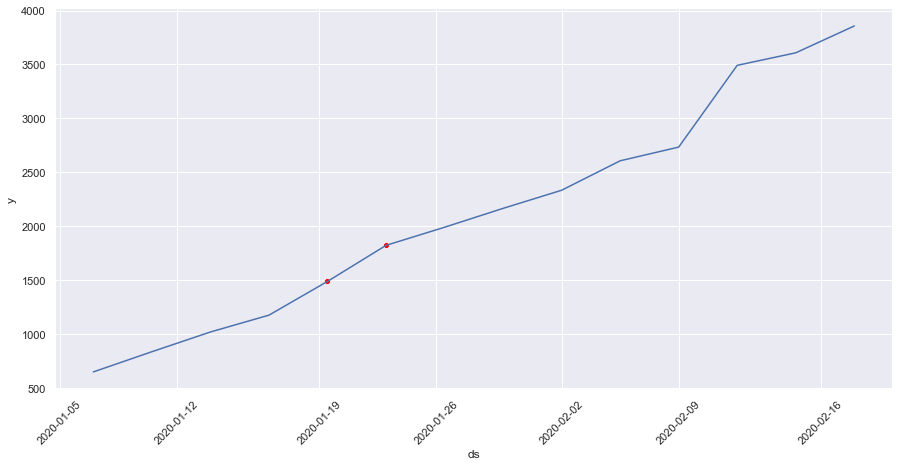

In [77]:
# Посмотрим на данные и отметим неделю, в которую была проведена акция

ax = sns.lineplot(x='ds', y='y', data=df)
bx = sns.scatterplot(x='ds', y='y', data=df.query('ds >= "2020-02-02" and ds <= "2020-02-09"'), color='red')
ax.set_xticklabels(labels=df.ds.dt.date, rotation=45, fontdict={'fontsize': 11})
sns.despine()

#######################################

Из графика видим несколько участков роста продаж:
    - в неделю c 2020-02-02 по 2020-02-09 
    - в неделю c 2020-03-15 по 2020-03-22
    
Воспользуемся простым аддитивным регрессором, равным разности продаж между заданной и предыдущей неделей

#######################################

In [6]:
# Теперь немного придется посчитать вручную
# Вычислим разницу продаж между двумя неделями и для удобства добавим в отдельный столбец исходного df

r1_list = [np.nan]
for i in range(len(df.y)):
    if i>0:
        r1_list.append(df.y[i]-df.y[i-1])
df['difference'] = r1_list

In [7]:
df

ds     y  difference
0  2020-01-05   650         NaN
1  2020-01-12   837       187.0
2  2020-01-19  1020       183.0
3  2020-01-26  1176       156.0
4  2020-02-02  1489       313.0
5  2020-02-09  1823       334.0
6  2020-02-16  1991       168.0
7  2020-02-23  2166       175.0
8  2020-03-01  2334       168.0
9  2020-03-08  2607       273.0
10 2020-03-15  2734       127.0
11 2020-03-22  3492       758.0
12 2020-03-29  3608       116.0
13 2020-04-05  3857       249.0

In [8]:
# Взглянем на разницу
print(df[df.ds=='2020-02-09'].difference)
print(df[df.ds=='2020-03-22'].difference)

5    334.0
Name: difference, dtype: float64
11    758.0
Name: difference, dtype: float64


#######################################

Нас интересует рост продаж в конце двух недель:
    - c 2020-02-02 по 2020-02-09 продажи выросли на 334 
    - c 2020-03-15 по 2020-03-22 продажи выросли еще на 758
    
Напишем функцию, которая вычисляет данные для регрессора

Заодно удалим столбец difference, его мы добавили в df только для удобства

#######################################

In [9]:
def regr(date):
    if date <  pd.to_datetime('2020-02-09'):
        return 0
    if date <  pd.to_datetime('2020-03-22'):
        return 334
    if date >= pd.to_datetime('2020-03-22'):
        return 334+758

In [10]:
df.drop(columns='difference', inplace=True)
df['r1'] = df.ds.apply(lambda x: regr(x))

In [11]:
# Импортируем праздники

holidays_dict = holidays.RU(years=(2016, 2017, 2018, 2019, 2020, 2021))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
                          .reset_index()\
                          .rename(columns={'index':'ds', 0:'holiday'})
df_holidays.ds = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds']).reset_index(drop=True)

### Обучение и проверка ошибки модели

    "Отрежем" часть данных
    Обучим модель на них
    Попробуем предсказать "отрезанную" часть данных
    Сравниваем предсказанные и реальные значения, вычисляем ошибку

In [84]:
# "Отрежем" данные примерно посередине
threshold_date = pd.to_datetime('2020-02-28')

# Создаем два df:
#     - для обучения модели
#     - для проверки модели
mask = df['ds'] < threshold_date

df_train = df[mask] [['ds', 'y', 'r1']]
df_test  = df[~mask][['ds', 'y', 'r1']]

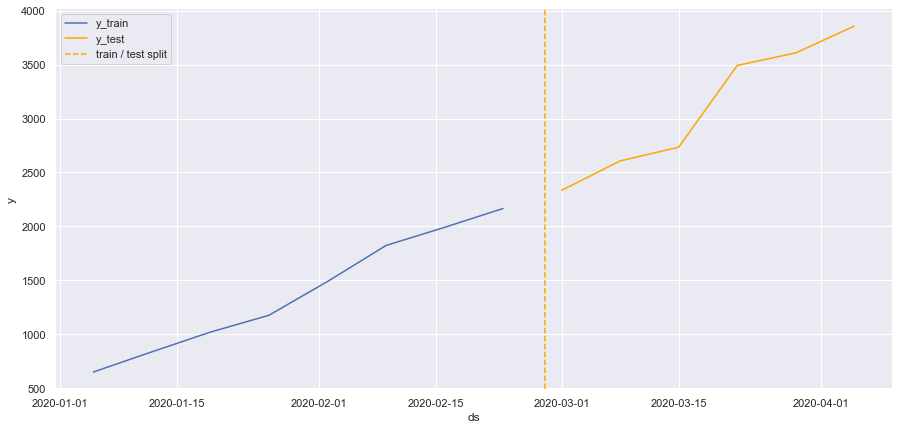

In [85]:
# Посмотрим наглядно
fig, ax = plt.subplots()
sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax, color='orange')
ax.axvline(threshold_date, color='orange', linestyle='--', label='train / test split')
ax.legend(loc='upper left')
sns.despine()

#######################################

Facebook Prophet позволяет учитывать сезонность данных, т.е. колебания данных в пределах:
    - дня
    - недели
    - года
    
Т.к. у нас есть данные только понедельно, то мы не можем учитывать сезонность в пределах дня и недели
Годовую сезонность мы тоже не сможем учесть, т.к. у нас данные всего лишь за 3 месяца

Можно было бы создать кастомную сезонность в пределах месяца, но для каждого месяца у нас будет всего 4 точки - этого мало для качественной составляющей, что приводит к увеличению ошибки между предсказанными и реальными данными

#######################################

In [86]:
# Создаем экземпляр типа Prophet
m = Prophet(daily_seasonality=False, 
            weekly_seasonality=False, 
            yearly_seasonality=False,
            holidays=df_holidays)

# Добавляем регрессор в модель
m.add_regressor('r1', mode='additive')

# m.add_seasonality(
#         name='monthly', 
#         period=4,
#         fourier_order=1
#     )

# Обучаем модель на тренировочных данных
m.fit(df_train)

# Создаем результирующий ДатаФрейм
# Параметры:
#     periods - отвечает за количество прогнозируемых периодов
#     freq    - единица периода (неделя, месяц, год и т.д.)

future = m.make_future_dataframe(periods=df_test.shape[0], freq='w')
# Добавляем значения регрессора
future['r1'] = future.ds.apply(lambda x: regr(x))
# Прогнозируем данные
forecast = m.predict(df=future)

INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
C:\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



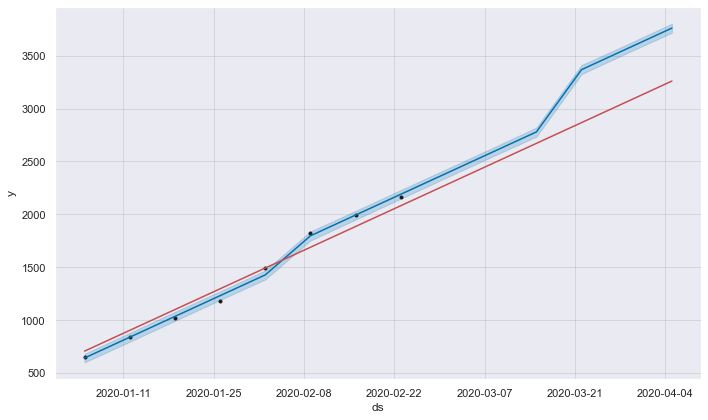

In [87]:
# Смотрим, что получилось
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

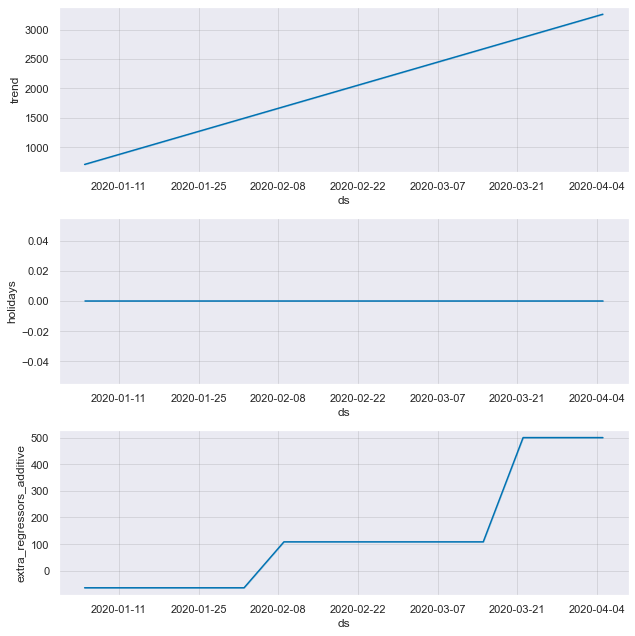

In [88]:
# Посмотрим на компоненты нашей модели
fig = m.plot_components(forecast)

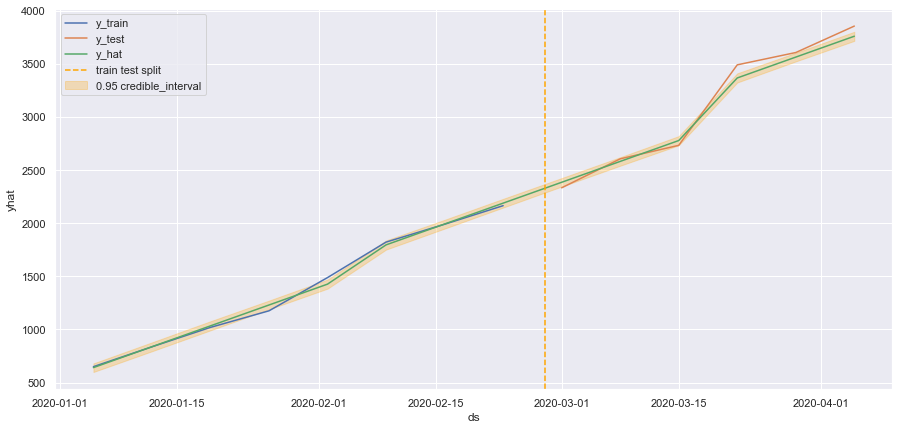

In [90]:
# Тут на графике:
#     - реальные данные тренировочные y_train
#     - реальные данные для тестирования модели y_test
#     - смоделированные значения y_hat
#     - границы 95% доверительного интервала (0.95 credible_interval)

fig, ax = plt.subplots()

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color='orange', 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, color='orange', linestyle='--', label='train test split')
ax.legend(loc='upper left')

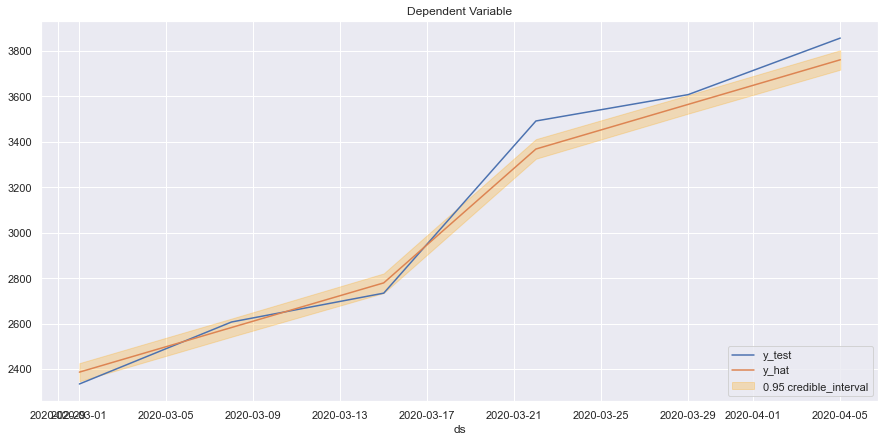

In [113]:
# Взглянем поближе на данные для тестирования модели

mask2 = forecast['ds'] < threshold_date
forecast_train = forecast[mask2]
forecast_test = forecast[~mask2]

fig, ax = plt.subplots()

ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['yhat_lower'],
    y2=forecast_test['yhat_upper'],
    color='orange', 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.legend(loc='lower right')
ax.set(title='Dependent Variable', ylabel='');

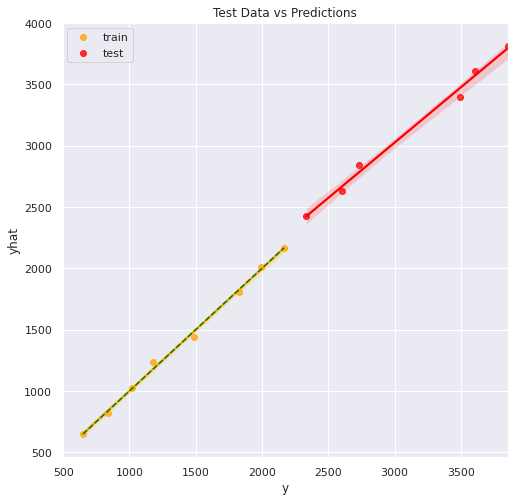

In [74]:
# Взглянем на scatterplot

fig, ax = plt.subplots(figsize=(8,8))

# Generate diagonal line to plot. 
d_x = np.linspace(start=df_train['y'].min() - 1, stop=df_train['y'].max() + 1, num=100)

sns.regplot(x=df_train['y'], y=forecast_train['yhat'], color='orange', label='train', ax=ax)
sns.regplot(x=df_test['y'], y=forecast_test['yhat'], color='red', label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color='green', ax=ax)
ax.lines[2].set_linestyle('--')
ax.set(title='Test Data vs Predictions');

########################

    Предсказанные значения лежат довольно близко к имеющимся
    Посмотрим на распределение ошибок и посчитаем ошибку модели
    
########################   

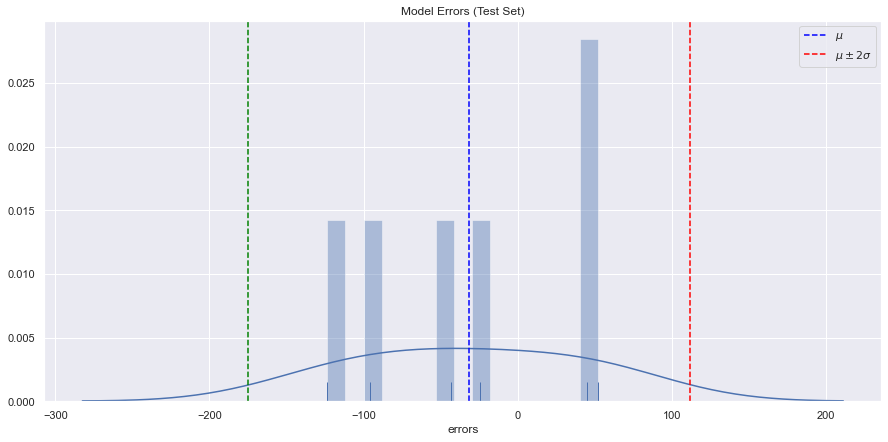

In [118]:
# Посмотрим распределение ошибок

forecast_test = forecast_test.merge(df_test[['ds', 'y']], on='ds')
forecast_test['errors'] = forecast_test['yhat'] - forecast_test['y']

errors_mean = forecast_test['errors'].mean()
errors_std = forecast_test['errors'].std()

fig, ax = plt.subplots()

sns.distplot(a=forecast_test['errors'], ax=ax, bins=15, rug=True)
ax.axvline(x=errors_mean, color='blue', linestyle='--', label=r'$\mu$')
ax.axvline(x=errors_mean + 2*errors_std, color='red', linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axvline(x=errors_mean - 2*errors_std, color='green', linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

########################

    Ошибки лежат в пределах 95% доверительного интервала
    
########################

In [127]:
# Посчитаем среднюю ошибку модели
# Но тут стоит учитывать то, что точек для расчета ошибки у нас довольно мало (всего лишь 6)

cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']

print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-df_test.shape[0]:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-df_test.shape[0]:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  2.0047489276349615 %
MAE (средняя абсолютная ошибка) –  63.95895772427267


########################################################################################################################

### Замечание: 

Не смотря на получившуюся абсолютную ошибку всего в 2%, в этих данных есть несколько проблем, которые сильно ограничивают возможности прогнозирования:

    1) Нет данных за предыдущие периоды, не понятно, на какой стадии развития находится ритейл.
        Продажи не могут расти бесконечно и неясно, в какой момент рост продаж начнет замедляться.
    2) Данные даны понедельно, а не по дням. Это затрудняет учет сезонностей и праздников моделью Facebook Prophet.
    3) Количество точек слишком мало для точной оценки MAPE и грамотной оценки качества модели (и построения тоже) при помощи Fаcebook Prophet
    
### Вывод:

    При помощи данного набора данных возможно построить тривиальный прогноз, но построить качественную модель и достоверно оценить ее ошибку на данном датасете весьма затруднительно.
    
########################################################################################################################

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.
C:\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



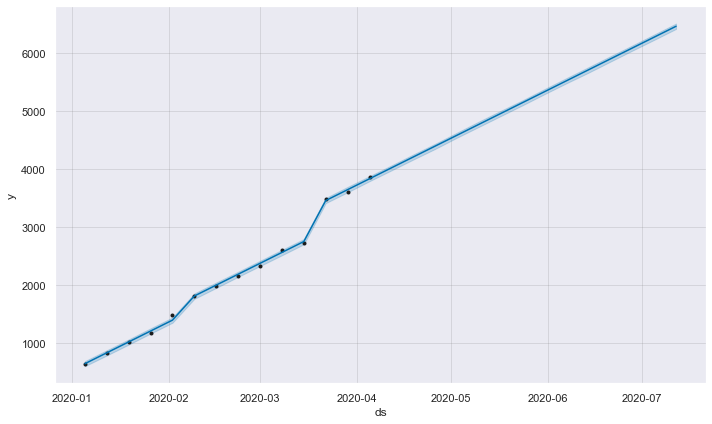

In [12]:
# Прогнозируем на полный период (df на три месяца, поэтому просто берем его df.shape[0])

f = Prophet(daily_seasonality=False, 
            weekly_seasonality=False, 
            yearly_seasonality=False,
            holidays=df_holidays)
f.add_regressor('r1', mode='additive')

f.fit(df)
future = f.make_future_dataframe(periods=df.shape[0], freq='w')
future['r1'] = future.ds.apply(lambda x: regr(x))
final_forecast = f.predict(df=future)
f.plot(final_forecast);

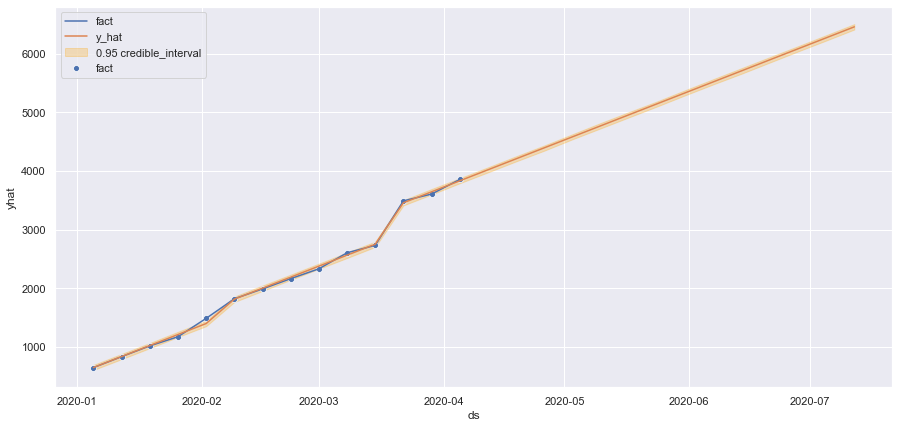

In [25]:
# Рисуем график с границами прогноза на полном периоде

fig, ax = plt.subplots()

ax.fill_between(
    x=final_forecast['ds'],
    y1=final_forecast['yhat_lower'],
    y2=final_forecast['yhat_upper'],
    color='orange', 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='fact', data=df, ax=ax)
sns.scatterplot(x='ds', y='y', label='fact', data=df, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=final_forecast, ax=ax)
ax.legend(loc='upper left')
sns.set(rc={'figure.figsize': (15,7)})
sns.set_style('darkgrid')

In [13]:
# Красивый интерактивный график

iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat'], name='yhat'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['trend'], name='trend')
])

In [130]:
# Выгружаем спрогнозированные данные в Эксель
final_forecast.to_excel("./app_forecast.xlsx", sheet_name='Data', index=False, encoding="cp1251")